In [1]:
import s3fs
import zarr
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import dask.array as da
from pyspark.sql import SparkSession

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# Loading MAST Data With Spark

First we need to connect to the S3 file system

In [2]:
s3 = s3fs.S3FileSystem(
    anon=False,
    key='minio99',
    secret='minio123',
    use_ssl=False,
    client_kwargs={
        'endpoint_url': "http://localhost:10101" # tried 127.0.0.1:9000 with no success
    }
)

Then we need to create a spark context. This includes the number of parallel processes to use. In our case we are using 4 processes on the local machine.

In [3]:
spark = (SparkSession.builder
      .master("local[4]")
      .appName("mast")
      .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/07/31 07:42:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Open the relevant Zarr archive and get the groups

In [4]:
store = s3fs.S3Map(root=f'mast/amc_test.zarr', s3=s3, check=False)
handle = zarr.open_consolidated(store)
groups = list(handle.groups())

We're going to perform a simple plotting task. We will:

 - Load the plasma current data as a `xarray.Dataset`
 - Slice every shot between 0 seconds and .2 seconds.
 
In the cell below we do not perform any computation. We only setup the operations we wish to perform.

In [5]:
def load_group(group):
    dataset = xr.Dataset(
        dict(data=xr.DataArray(group['data'], dims=['time']),
             error=xr.DataArray(group['error'], dims=['time']), 
            time=xr.DataArray(group['time'], dims=['time'])))
    return dataset
    
rdd = spark.sparkContext.parallelize(reversed(groups), 10)
rdd = rdd.map(lambda item: load_group(item[1]))
rdd = rdd.map(lambda dataset: dataset.sel(time=slice(0, .3)))
rdd = rdd.cache()

Finally, we want to plot the last 10 shots. `rdd.take` will process just `10` items and return the results as a list 

CPU times: user 42.3 ms, sys: 0 ns, total: 42.3 ms
Wall time: 4.24 s


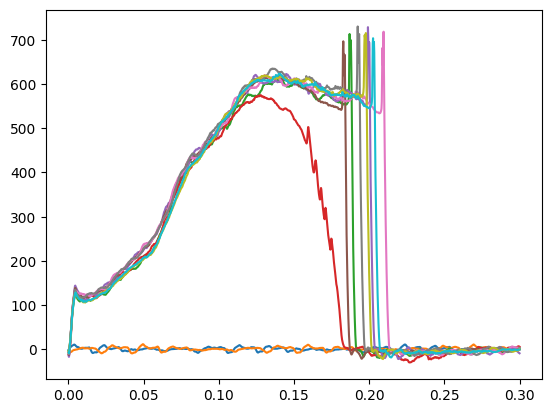

In [6]:
%%time
for current in rdd.take(10):
    plt.plot(current.time, current.data)

### Fast Reductions for Analysis

Let's try something more compute intensive. Here we are going to:

 - Load all of the plasma current data each as a `xarray.Dataset`
 - Slice the current between `0` and `.2` seconds
 - Take the average of the plasma current
 - Filter any shots with an average current less than `5.0`
 
Again, below we only setup the computational steps. The next cell will execute the reduction.

In [7]:
def load_group(group):
    dataset = xr.Dataset(
        dict(data=xr.DataArray(group['data'], dims=['time']),
             error=xr.DataArray(group['error'], dims=['time']), 
            time=xr.DataArray(group['time'], dims=['time'])))
    return dataset
    
rdd = spark.sparkContext.parallelize(reversed(groups), 10)
keys = rdd.map(lambda item: int(item[0]))

rdd = rdd.map(lambda item: load_group(item[1]))
rdd = rdd.map(lambda dataset: dataset.sel(time=slice(0., .2)))
rdd = rdd.map(lambda dataset: dataset['data'].mean().values)
rdd.cache()

result = keys.zip(rdd).filter(lambda item: item[1] > 5.0)

Let's collect the results and plot the average current as a function of shot number

CPU times: user 37.4 ms, sys: 12.8 ms, total: 50.1 ms
Wall time: 8.68 s


Text(0, 0.5, 'current')

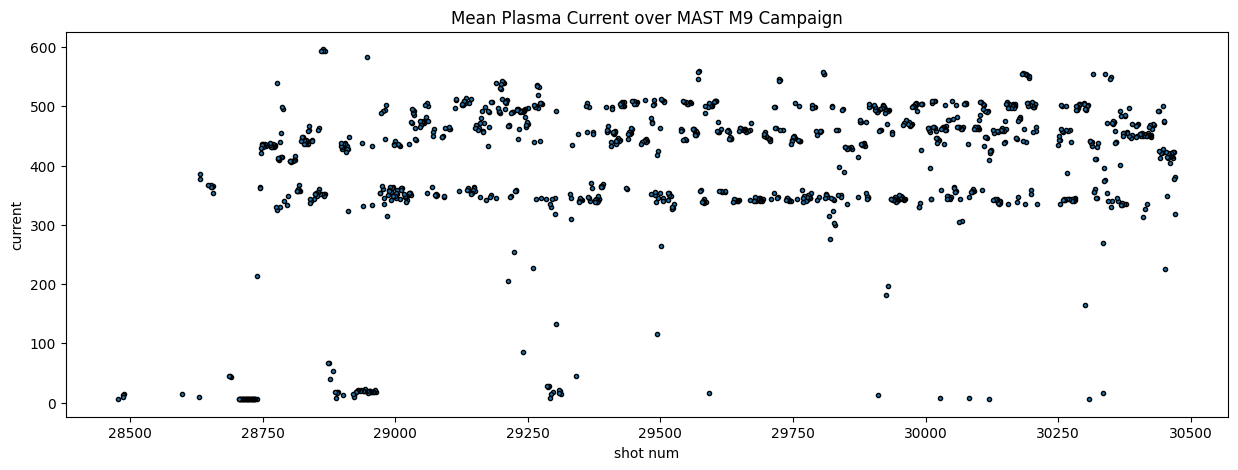

In [8]:
%%time
results = result.collect()
df = pd.DataFrame(results, columns=['shot', 'mean_current'])

plt.figure(figsize=(15, 5))
plt.scatter(df.shot, df.mean_current, marker='.', edgecolor='black')
plt.title('Mean Plasma Current over MAST M9 Campaign')
plt.xlabel('shot num')
plt.ylabel('current')